In [162]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# 3. Data Scaling

* Due to the different types of information that Categorical features and Numerical features provide, each requires unique data scaling methods. Therefore, before normalizing features, we must split them into numeric and categorical sets.
* Regarding the numerical variables, the objective is to place them into the same scale, from 0 to 1, where 1 refers to the maximum value of the feature while 0 refers to the minimum value of the feature. One reason for normalizing / scaling the data is to prevent the model from giving more importance to variables with larger absolute numbers, since we do not want to make any assumptions on the level of importance of each feature. It is relevant to mention that while scaling we only consider information obtained from the training data. Only after we can use the minimum and maximum values of the training dataset for each variable to scale the validation dataset.
* Concerning categorical features, these are encoded to be readable by the models, as these do not typically process non-numeric data directly. To do so, we used the Ordinal Encoder method to transform the categorical variables by assigning each category an unique integer based on its order or occurrence


In [163]:
# load the data (train and test)
X_train_DS = pd.read_csv('datasets/feature_engineering_train_delivery1.csv', index_col=0)
X_val_DS = pd.read_csv('datasets/feature_engineering_val_delivery1.csv', index_col=0)
y_train_DS = pd.read_csv('datasets/feature_engineering_y_train_delivery1.csv', index_col=0)
y_val_DS = pd.read_csv('datasets/feature_engineering_y_val_delivery1.csv', index_col=0)

X_test_DS = pd.read_csv('datasets/feature_engineering_test_delivery1.csv', index_col=0)

In [164]:
X_train_DS.shape, y_train_DS.shape, X_val_DS.shape,  y_val_DS.shape

((441804, 51), (441804, 1), (110586, 51), (110586, 1))

In [165]:
X_train_DS.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Number of Dependents', 'Assembly Year', 'Accident Year',
       'Assembly Month', 'Accident Month', 'Age Group',
       'Frequent Injury Cause', 'Broad Body Part',
       'Dependency-to-Income Ratio', 'Injury-Location Pair',
       'Time Between Events', 'Accident on Weekday', 'Injury Complexity',
       'Carrier Accident Density', 'Season of Ac

In [166]:
X_val_DS.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Number of Dependents', 'Assembly Year', 'Accident Year',
       'Assembly Month', 'Accident Month', 'Age Group',
       'Frequent Injury Cause', 'Broad Body Part',
       'Dependency-to-Income Ratio', 'Injury-Location Pair',
       'Time Between Events', 'Accident on Weekday', 'Injury Complexity',
       'Carrier Accident Density', 'Season of Ac

In [167]:
X_train_DS['Accident on Weekday'] = X_train_DS['Accident on Weekday'].map({True: 1, False: 0})
X_val_DS['Accident on Weekday'] = X_val_DS['Accident on Weekday'].map({True: 1, False: 0})

In [168]:
print(X_train_DS['Medical Fee Region'].dropna().unique())  # Excludes NaN explicitly


['IV' 'I' 'II' 'III']


In [169]:
mapping = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'UK': 0}  # Assign a value to 'UK' based on its meaning
X_train_DS['Medical Fee Region'] = X_train_DS['Medical Fee Region'].map(mapping)
X_val_DS['Medical Fee Region'] = X_val_DS['Medical Fee Region'].map(mapping)

In [170]:
X_train_DS.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Number of Dependents', 'Assembly Year', 'Accident Year',
       'Assembly Month', 'Accident Month', 'Age Group',
       'Frequent Injury Cause', 'Broad Body Part',
       'Dependency-to-Income Ratio', 'Injury-Location Pair',
       'Time Between Events', 'Accident on Weekday', 'Injury Complexity',
       'Carrier Accident Density', 'Season of Ac

In [171]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year',
                    'Assembly Year', 'Dependency-to-Income Ratio', 'Time Between Events',
                    'Carrier Accident Density', 'Industry Claim Percentage', 'Region Risk Percentage', 'Geo-Industry Risk' ]
                    
categorical_features = ['Accident Date','Assembly Date','Carrier Name', 'Carrier Type', 'County of Injury','District Name',
                        'Industry Code', 'Industry Code Description', 'Medical Fee Region',
                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description','C-2 Date',
                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Age Group', 'Broad Body Part', 'Injury-Location Pair',
                        'Injury Complexity', 'Season of Accident', 'Region Risk Level', 'Industry Risk Level']
                        
binary_features = ['IME-4 Count','Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', 
                   'First Hearing Date', 'Gender','Frequent Injury Cause', 'Accident on Weekday', 'Both C2 and C3', 'C-3 Date',
                   'Only C2', 'Only C3', 'No C2 or C3']

cyclic_features = ['Accident Month', 'Assembly Month']


In [172]:
X_train_numeric = X_train_DS[numeric_features]
X_train_categorical = X_train_DS[categorical_features]
X_train_binary = X_train_DS[binary_features]
X_train_cyclic = X_train_DS[cyclic_features]

X_val_numeric = X_val_DS[numeric_features]
X_val_categorical = X_val_DS[categorical_features]
X_val_binary = X_val_DS[binary_features]
X_val_cyclic = X_val_DS[cyclic_features]

X_test_numeric = X_test_DS[numeric_features]
X_test_categorical = X_test_DS[categorical_features]
X_test_binary = X_test_DS[binary_features]
X_test_cyclic = X_test_DS[cyclic_features]

## 3.1 Data Scaling for Numerical

In [173]:
# Call function
scaler = MinMaxScaler()

# Fit to training data
scaler.fit(X_train_numeric)

# Transform training data
X_train_numeric_scaled = scaler.transform(X_train_numeric)

# Check results
X_train_numeric_scaled

array([[0.52307692, 0.51664963, 0.49275362, ..., 0.17840261, 0.2304303 ,
        0.03459687],
       [0.44615385, 0.08206957, 0.56521739, ..., 1.        , 0.71952476,
        0.67458885],
       [0.27692308, 0.68142501, 0.71014493, ..., 0.06735314, 0.98152086,
        0.05074208],
       ...,
       [0.23076923, 0.08206957, 0.75362319, ..., 0.28785424, 0.41020189,
        0.0657842 ],
       [0.52307692, 0.08206957, 0.47826087, ..., 1.        , 0.89846336,
        1.        ],
       [0.10769231, 0.08206957, 0.89855072, ..., 0.22849027, 0.98152086,
        0.31016847]])

In [174]:
# Convert array into a pandas df

X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled, columns=X_train_numeric.columns, index=X_train_numeric.index)
X_train_numeric_scaled.head()

,Age at Injury,Average Weekly Wage,Birth Year,Number of Dependents,Accident Year,Assembly Year,Dependency-to-Income Ratio,Time Between Events,Carrier Accident Density,Industry Claim Percentage,Region Risk Percentage,Geo-Industry Risk
Claim Identifier,,,,,,,,,,,,
5840724,0.523077,0.516650,0.492754,0.166667,0.916667,0.5,0.003431,0.000000,1.000000,0.178403,0.230430,0.034597
5828518,0.446154,0.082070,0.565217,0.500000,0.916667,0.5,0.061760,0.000000,1.000000,1.000000,0.719525,0.674589
5623558,0.276923,0.681425,0.710145,0.666667,0.833333,0.0,0.010429,0.000000,0.022834,0.067353,0.981521,0.050742
5630561,0.230769,0.082070,0.753623,0.333333,0.833333,0.5,0.041173,0.083333,0.157068,1.000000,0.898463,1.000000
5708079,0.646154,0.082070,0.376812,0.500000,0.916667,0.5,0.061760,0.000000,0.013070,0.287854,0.022666,0.003911


In [175]:
print(X_val_numeric.dtypes)


Age at Injury                 float64
Average Weekly Wage           float64
Birth Year                    float64
Number of Dependents          float64
Accident Year                   int64
Assembly Year                   int64
Dependency-to-Income Ratio    float64
Time Between Events             int64
Carrier Accident Density      float64
Industry Claim Percentage     float64
Region Risk Percentage        float64
Geo-Industry Risk             float64
dtype: object


In [176]:
# Scale validation set too and convert it to pandas df

X_val_numeric_scaled = scaler.transform(X_val_numeric)
X_val_numeric_scaled = pd.DataFrame(X_val_numeric_scaled, columns=X_val_numeric.columns, index=X_val_numeric.index)

In [177]:
# Scale test set too and convert it to pandas df

X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns=X_test_numeric.columns, index=X_test_numeric.index)

## 3.2 Data Scaling for Categorical

In [178]:
X_train_categorical.columns

Index(['Accident Date', 'Assembly Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'District Name', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'C-2 Date', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description',
       'Zip Code', 'Age Group', 'Broad Body Part', 'Injury-Location Pair',
       'Injury Complexity', 'Season of Accident', 'Region Risk Level',
       'Industry Risk Level'],
      dtype='object')

In [179]:
X_train_categorical.head()

,Accident Date,Assembly Date,Carrier Name,Carrier Type,County of Injury,District Name,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,...,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Age Group,Broad Body Part,Injury-Location Pair,Injury Complexity,Season of Accident,Region Risk Level,Industry Risk Level
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5840724,2021-10-20,2021-10-22,STATE INSURANCE FUND,2A. SIF,RICHMOND,NYC,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,4,25.0,...,42.0,LOWER BACK AREA,10304.0,Adult,Trunk,42.0 - NO PHYSICAL INJURY,2.0,Autumn,Low Risk,Low Risk
5828518,2021-10-04,2021-10-06,STATE INSURANCE FUND,2A. SIF,NASSAU,NYC,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,4,2.0,...,35.0,HAND,11520.0,Adult,Upper Extremities,35.0 - BURN,16.0,Autumn,Low Risk,Low Risk
5623558,2020-11-19,2020-12-22,TRAVELERS INDEMNITY CO OF CONN,1A. PRIVATE,QUEENS,NYC,52.0,FINANCE AND INSURANCE,4,97.0,...,34.0,WRIST,11358.0,Adult,Upper Extremities,34.0 - CARPAL TUNNEL SYNDROME,390.0,Autumn,Low Risk,Low Risk
5630561,2020-12-09,2021-01-06,AMERICAN ZURICH INSURANCE CO,1A. PRIVATE,KINGS,NYC,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,4,83.0,...,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11236.0,Adult,Multiple Body Parts,90.0 - COVID-19,249.0,Winter,Low Risk,Low Risk
5708079,2021-03-10,2021-04-26,AMERICAN CASUALTY CO OF,1A. PRIVATE,TOMPKINS,BINGHAMTON,23.0,CONSTRUCTION,1,98.0,...,35.0,HAND,14850.0,Old,Upper Extremities,35.0 - STRAIN OR TEAR,208.0,Spring,Low Risk,Low Risk


In [180]:
#We're having a cardinality issue, with a lot of features. One Hot Encoder is generating a lot of columns due to it.
# We will assess that problem here and then maybe drop some redundant features.

# Check cardinality of categorical features
cardinality = X_train_categorical.nunique()
cardinality

Accident Date                        3046
Assembly Date                         891
Carrier Name                         1428
Carrier Type                            8
County of Injury                       63
District Name                           8
Industry Code                          24
Industry Code Description              20
Medical Fee Region                      4
WCIO Cause of Injury Code              77
WCIO Cause of Injury Description       74
WCIO Nature of Injury Code             51
WCIO Nature of Injury Description      51
C-2 Date                             1746
WCIO Part Of Body Code                 56
WCIO Part Of Body Description          54
Zip Code                             7122
Age Group                               4
Broad Body Part                         9
Injury-Location Pair                 1742
Injury Complexity                     262
Season of Accident                      4
Region Risk Level                       1
Industry Risk Level               

We need to fix the high cardinality issue before encoding the categorical features. We will use the following strategies:
  - Analyse the cardinality of each feature and check if we can drop it
    - Feature 1 with high cardinality : Carrier Name:
      - As we've seen in the EDA, the Carrier Name feature has a high correlation with Carrier Type. Given That, we are dropping it
    - Feature 2 with high cardinality: Zip code:
      - As we've seen in the EDA, the Zip code feature has a high correlation with the County of Injury and Medical Fee Region. Given That, we are dropping it

In [181]:
#remove the values 'Carrier Name' and 'Zip Code' from the list of categorical features

X_train_categorical = X_train_categorical.drop(['Carrier Name', 'Zip Code'], axis=1)
X_val_categorical = X_val_categorical.drop(['Carrier Name', 'Zip Code'], axis=1)
X_test_categorical = X_test_categorical.drop(['Carrier Name', 'Zip Code'], axis=1)

# Check cardinality of categorical features

X_train_categorical.nunique()

Accident Date                        3046
Assembly Date                         891
Carrier Type                            8
County of Injury                       63
District Name                           8
Industry Code                          24
Industry Code Description              20
Medical Fee Region                      4
WCIO Cause of Injury Code              77
WCIO Cause of Injury Description       74
WCIO Nature of Injury Code             51
WCIO Nature of Injury Description      51
C-2 Date                             1746
WCIO Part Of Body Code                 56
WCIO Part Of Body Description          54
Age Group                               4
Broad Body Part                         9
Injury-Location Pair                 1742
Injury Complexity                     262
Season of Accident                      4
Region Risk Level                       1
Industry Risk Level                     1
dtype: int64

We can also see that there are features that have a code and a given description. We will reduce the model interpretabilty but we will drop the description and keep the code. The features we are dropping are:
- Industry Code Description 
- WCIO Cause of Injury Description
- WCIO Nature of Injury Description
- WCIO Part Of Body Description

In [182]:
#remove the values 'Carrier Name' and 'Zip Code' from the list of categorical features

X_train_categorical = X_train_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)
X_val_categorical = X_val_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)

# Check cardinality of categorical features

X_train_categorical.nunique()

Accident Date                 3046
Assembly Date                  891
Carrier Type                     8
County of Injury                63
District Name                    8
Industry Code                   24
Medical Fee Region               4
WCIO Cause of Injury Code       77
WCIO Nature of Injury Code      51
C-2 Date                      1746
WCIO Part Of Body Code          56
Age Group                        4
Broad Body Part                  9
Injury-Location Pair          1742
Injury Complexity              262
Season of Accident               4
Region Risk Level                1
Industry Risk Level              1
dtype: int64

In [183]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd

low_cardinality_threshold = 10

# Separate columns based on cardinality
low_cardinality_cols = [col for col in X_train_categorical.columns if X_train_categorical[col].nunique() <= low_cardinality_threshold]
high_cardinality_cols = [col for col in X_train_categorical.columns if X_train_categorical[col].nunique() > low_cardinality_threshold]

# Apply One-Hot Encoding to Low Cardinality Columns
ohc = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")

ohc_train_feat = ohc.fit_transform(X_train_categorical[low_cardinality_cols])
ohc_val_feat = ohc.transform(X_val_categorical[low_cardinality_cols])
ohc_test_feat = ohc.transform(X_test_categorical[low_cardinality_cols])


In [184]:
# Create DataFrames for one-hot encoded features
ohc_train_df = pd.DataFrame(ohc_train_feat, index=X_train_categorical.index, columns=ohc.get_feature_names_out(low_cardinality_cols))
ohc_val_df = pd.DataFrame(ohc_val_feat, index=X_val_categorical.index, columns=ohc.get_feature_names_out(low_cardinality_cols))

In [185]:
# Apply Frequency Encoding to High Cardinality Columns
for col in high_cardinality_cols:
    freq_map = X_train_categorical[col].value_counts(normalize=True)
    X_train_categorical[col] = X_train_categorical[col].map(freq_map)
    X_val_categorical[col] = X_val_categorical[col].map(freq_map)

# Create DataFrames for frequency-encoded features
freq_train_df = X_train_categorical[high_cardinality_cols]
freq_val_df = X_val_categorical[high_cardinality_cols]


In [186]:
# Apply Min-Max Scaling to Frequency Encoded Features
scaler = MinMaxScaler()
freq_train_scaled = scaler.fit_transform(freq_train_df)
freq_val_scaled = scaler.transform(freq_val_df)

# Convert scaled frequency features back to DataFrames
freq_train_scaled_df = pd.DataFrame(freq_train_scaled, index=freq_train_df.index, columns=freq_train_df.columns)
freq_val_scaled_df = pd.DataFrame(freq_val_scaled, index=freq_val_df.index, columns=freq_val_df.columns)

In [187]:
# Combine Both Encoded DataFrames
X_train_processed = pd.concat([ohc_train_df, freq_train_scaled_df], axis=1)
X_val_processed = pd.concat([ohc_val_df, freq_val_scaled_df], axis=1)

# Check the shapes of the processed DataFrames
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")

# Output the final DataFrames
X_train_processed.head(), X_val_processed.head()

Processed training data shape: (441804, 41)
Processed validation data shape: (110586, 41)


(                  Carrier Type_2A. SIF  Carrier Type_3A. SELF PUBLIC  \
 Claim Identifier                                                       
 5840724                            1.0                           0.0   
 5828518                            1.0                           0.0   
 5623558                            0.0                           0.0   
 5630561                            0.0                           0.0   
 5708079                            0.0                           0.0   
 
                   Carrier Type_4A. SELF PRIVATE  \
 Claim Identifier                                  
 5840724                                     0.0   
 5828518                                     0.0   
 5623558                                     0.0   
 5630561                                     0.0   
 5708079                                     0.0   
 
                   Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)  \
 Claim Identifier                         

## 3.3 Data Scaling for Cyclical Features

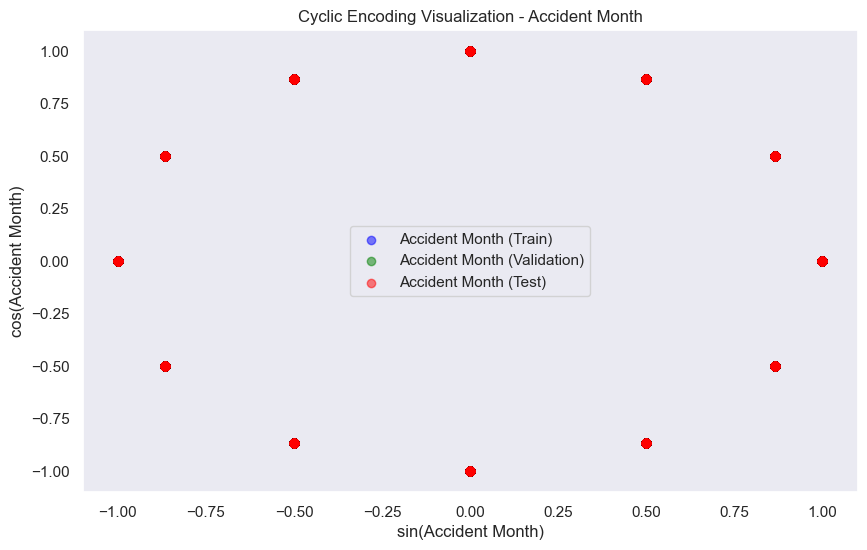

In [188]:
def cyclic_encode(data, columns, max_value):
    """
    Applies cyclic encoding to specified columns in the data.

    Parameters:
    - data: DataFrame containing the columns to encode.
    - columns: List of column names to encode.
    - max_value: Maximum value for the cyclic period (e.g., 12 for months).

    Returns:
    - Encoded DataFrame with '_sin' and '_cos' for each cyclic column.
    """
    for col in columns:
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col] / max_value)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col] / max_value)
        data.drop(columns=[col], inplace=True)
    return data

# Cyclic features and maximum value for months
cyclic_features = ['Accident Month', 'Assembly Month']
max_value = 12  # Max value for months in a year

# Apply cyclic encoding
X_train_cyclic_encoded = cyclic_encode(X_train_cyclic.copy(), cyclic_features, max_value)
X_val_cyclic_encoded = cyclic_encode(X_val_cyclic.copy(), cyclic_features, max_value)
X_test_cyclic_encoded = cyclic_encode(X_test_cyclic.copy(), cyclic_features, max_value)

# Visualize encoded features for a specific cyclic column (e.g., 'Accident Month')
plt.figure(figsize=(10, 6))

plt.scatter(
    X_train_cyclic_encoded['Accident Month_sin'], 
    X_train_cyclic_encoded['Accident Month_cos'], 
    label='Accident Month (Train)', alpha=0.5, color='blue'
)
plt.scatter(
    X_val_cyclic_encoded['Accident Month_sin'], 
    X_val_cyclic_encoded['Accident Month_cos'], 
    label='Accident Month (Validation)', alpha=0.5, color='green'
)
plt.scatter(
    X_test_cyclic_encoded['Accident Month_sin'], 
    X_test_cyclic_encoded['Accident Month_cos'], 
    label='Accident Month (Test)', alpha=0.5, color='red'
)

plt.title('Cyclic Encoding Visualization - Accident Month')
plt.xlabel('sin(Accident Month)')
plt.ylabel('cos(Accident Month)')
plt.legend()
plt.grid()
plt.show()

## 3.4 Data Scaling for Target

In [189]:
# Initialize the encoder
le = LabelEncoder()

# Fit and transform the target variable in the training set

y_train_encoded = le.fit_transform(y_train_DS)
y_train_encoded_df = pd.DataFrame(y_train_encoded, columns=['Encoded Target'], index=y_train_DS.index)

In [190]:
y_train_encoded_df

,Encoded Target
Claim Identifier,
5840724,3
5828518,1
5623558,4
5630561,2
5708079,1
...,...
6117605,1
5524219,3
5553447,1


In [191]:
y_val_encoded = le.transform(y_val_DS)
y_val_encoded_df = pd.DataFrame(y_val_encoded, columns=['Encoded Target'], index=y_val_DS.index)

In [192]:
y_val_encoded_df

,Encoded Target
Claim Identifier,
6003273,3
5659715,2
6070148,1
6108041,1
5519272,3
...,...
6066268,1
5704163,1
5579511,1


In [193]:
X_train_DS = pd.concat([X_train_numeric_scaled, X_train_processed, X_train_binary], axis=1)
X_val_DS = pd.concat([X_val_numeric_scaled, X_val_processed, X_val_binary], axis=1)

In [194]:
X_train_DS.shape, y_train_encoded_df.shape

((441804, 66), (441804, 1))

In [195]:
X_train_DS.to_csv('datasets/scaled_data_train_delivery1.csv')
y_train_encoded_df.to_csv('datasets/scaled_target_train_delivery1.csv')
X_val_DS.to_csv('datasets/scaled_data_val_delivery1.csv')
y_val_encoded_df.to_csv('datasets/scaled_target_val_delivery1.csv')
X_test_DS.to_csv('datasets/scaled_data_test_delivery1.csv')